In [ ]:
# %%

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
# Define training parameters
training_start_date = '1970-02-02'
training_end_date = '2024-06-01'
prediction_start_date = '2024-06-02'
prediction_end_date = '2024-10-25'
n_future = 1
batch_size = 16
hidden_size = 64
output_size = 1

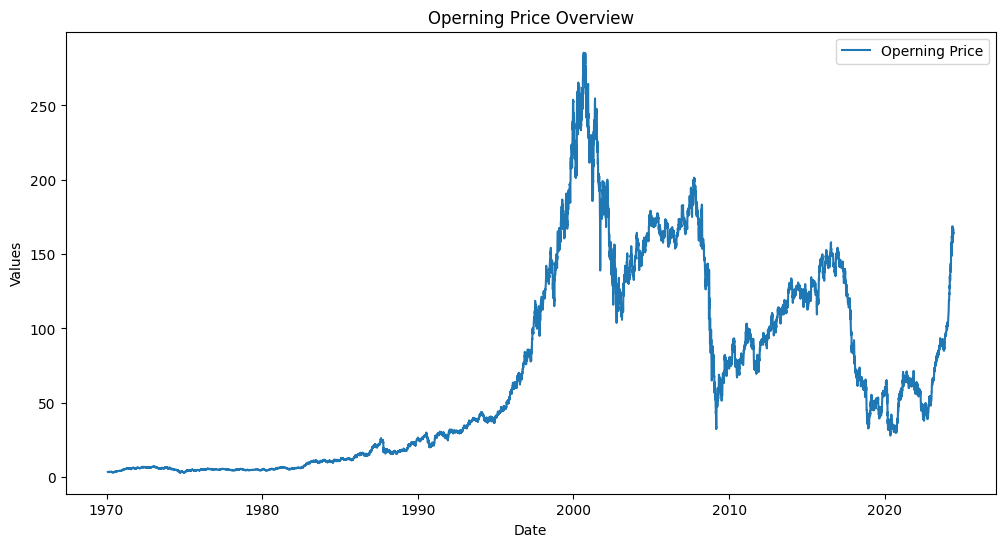

In [ ]:
# %% 

df_full = pd.read_csv('data/Yahoo/yahoo_finance.csv')
df_full['Date'] = pd.to_datetime(df_full['Date'])

cols = list(df_full)[1:2]  # Adjust based on your DataFrame structure
df_for_training = df_full[(df_full['Date'] >= training_start_date) & (df_full['Date'] <= training_end_date)][cols].astype(float)

# Convert 'Date' column to index for time series analysis
df_for_training.set_index(df_full[(df_full['Date'] >= training_start_date) & (df_full['Date'] <= training_end_date)]['Date'], inplace=True)

# Plot the time series data for a visual check
plt.figure(figsize=(12, 6))
plt.plot(df_for_training, label="Operning Price")
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Operning Price Overview')
plt.legend()
plt.show()

In [ ]:
# %%

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size // 2, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size // 2, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x[:, -1, :])  # Use only the last output
        x = self.fc(x)
        return x


# Prepare the training data
def prepare_data(df, n_past):
    cols = list(df)[1:6]  # Adjust based on your DataFrame structure
    df_for_training = df[(df['Date'] >= training_start_date) & (df['Date'] <= training_end_date)][cols].astype(float)

    # Normalize training data 
    scaler = StandardScaler()
    df_for_training_scaled = scaler.fit_transform(df_for_training)

    # Prepare data for LSTM
    trainX, trainY = [], []
    for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
        trainX.append(df_for_training_scaled[i - n_past:i, :])
        trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])  # Predicting the first column

    trainX, trainY = np.array(trainX), np.array(trainY)
    return trainX, trainY, scaler, df_for_training, cols


# Define function to train model with a given window size
def train_model(n_past, patience=5, min_delta=0.001):
    trainX, trainY, scaler, df_for_training, cols = prepare_data(df_full, n_past)

    # Convert numpy arrays to torch tensors
    trainX = torch.from_numpy(trainX).float()
    trainY = torch.from_numpy(trainY).float().view(-1, 1)

    # Split the data into training and validation sets
    train_size = int(len(trainX) * 0.8)
    trainX_tensor, valX_tensor = trainX[:train_size], trainX[train_size:]
    trainY_tensor, valY_tensor = trainY[:train_size], trainY[train_size:]

    # Create data loaders for training and validation
    train_dataset = torch.utils.data.TensorDataset(trainX_tensor, trainY_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model, criterion, and optimizer
    model = LSTMModel(input_size=trainX.shape[2], hidden_size=hidden_size, output_size=output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Early stopping parameters
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(1000):  # Use a large number of epochs; training will stop early if needed
        model.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(valX_tensor)
            val_loss = criterion(val_outputs, valY_tensor).item()

        print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter if validation loss improves
            best_model_weights = model.state_dict()  # Save the best model weights
        else:
            patience_counter += 1

        # Stop if patience is reached
        if patience_counter >= patience:
            print("Early stopping triggered.")
            model.load_state_dict(best_model_weights)  # Restore best model weights
            break

    # Final validation metrics
    val_outputs = val_outputs.numpy()
    valY_tensor = valY_tensor.numpy()

    mse = mean_squared_error(valY_tensor, val_outputs)
    mae = mean_absolute_error(valY_tensor, val_outputs)
    r2 = r2_score(valY_tensor, val_outputs)

    # Make predictions
    make_predictions(n_past, model, scaler, df_for_training, cols)

    return mse, mae, r2

In [ ]:
# %%

# Define function to make predictions and visualize results
def make_predictions(n_past, model, scaler, df_for_training, cols):
    # Filter dataset by prediction date range
    df_prediction_temp = df_full[(df_full['Date'] >= prediction_start_date) & (df_full['Date'] <= prediction_end_date)]
    
    # Normalize prediction data
    df_prediction_scaled = scaler.transform(df_prediction_temp[cols].astype(float))

    predictionX = []
    for i in range(n_past, len(df_prediction_scaled) - n_future + 1):
        predictionX.append(df_prediction_scaled[i - n_past:i, :])

    predictionX = np.array(predictionX)
    predictionX_tensor = torch.from_numpy(predictionX).float()

    model.eval()
    with torch.no_grad():
        predictions = model(predictionX_tensor)

    # Inverse transform the predictions to original scale
    predictions_inverse = scaler.inverse_transform(
        np.concatenate([predictions.numpy(), np.zeros((predictions.shape[0], df_for_training.shape[1] - 1))], axis=1)
    )[:, 0]

    # Also inverse-transform actual values for comparison
    actual_values = df_prediction_temp['Open'].iloc[n_past:].values
    # Save predictions and actual values to CSV
    prediction_dates = df_prediction_temp['Date'].iloc[n_past:].values

    output_folder = "Prediction"
    os.makedirs(output_folder, exist_ok=True)
    
    # Define the full path for the output CSV
    output_csv_path = os.path.join(output_folder, f"Prediction_{n_past}.csv" )
    df_predictions = pd.DataFrame({
        'Date': prediction_dates,
        'Actual_Open': actual_values,
        'Predicted_Open': predictions_inverse
    })
    df_predictions.to_csv(output_csv_path, index=False)

    # Plotting Actual vs Predicted
    plt.figure(figsize=(14, 7))
    plt.plot(df_prediction_temp['Date'].iloc[n_past:], actual_values, label='Actual Open Prices', color='blue')
    plt.plot(df_prediction_temp['Date'].iloc[n_past:], predictions_inverse, label='Predicted Open Prices', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Open Price')
    plt.title(f'Actual vs Predicted Open Prices (Window Size: {n_past})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Epoch 1, Train Loss: 0.0105, Val Loss: 0.0012
Epoch 2, Train Loss: 0.0050, Val Loss: 0.0004
Epoch 3, Train Loss: 0.0028, Val Loss: 0.0001
Epoch 4, Train Loss: 0.0100, Val Loss: 0.0008
Epoch 5, Train Loss: 0.0075, Val Loss: 0.0000
Epoch 6, Train Loss: 0.0073, Val Loss: 0.0013
Epoch 7, Train Loss: 0.0026, Val Loss: 0.0006
Epoch 8, Train Loss: 0.0035, Val Loss: 0.0005
Early stopping triggered.


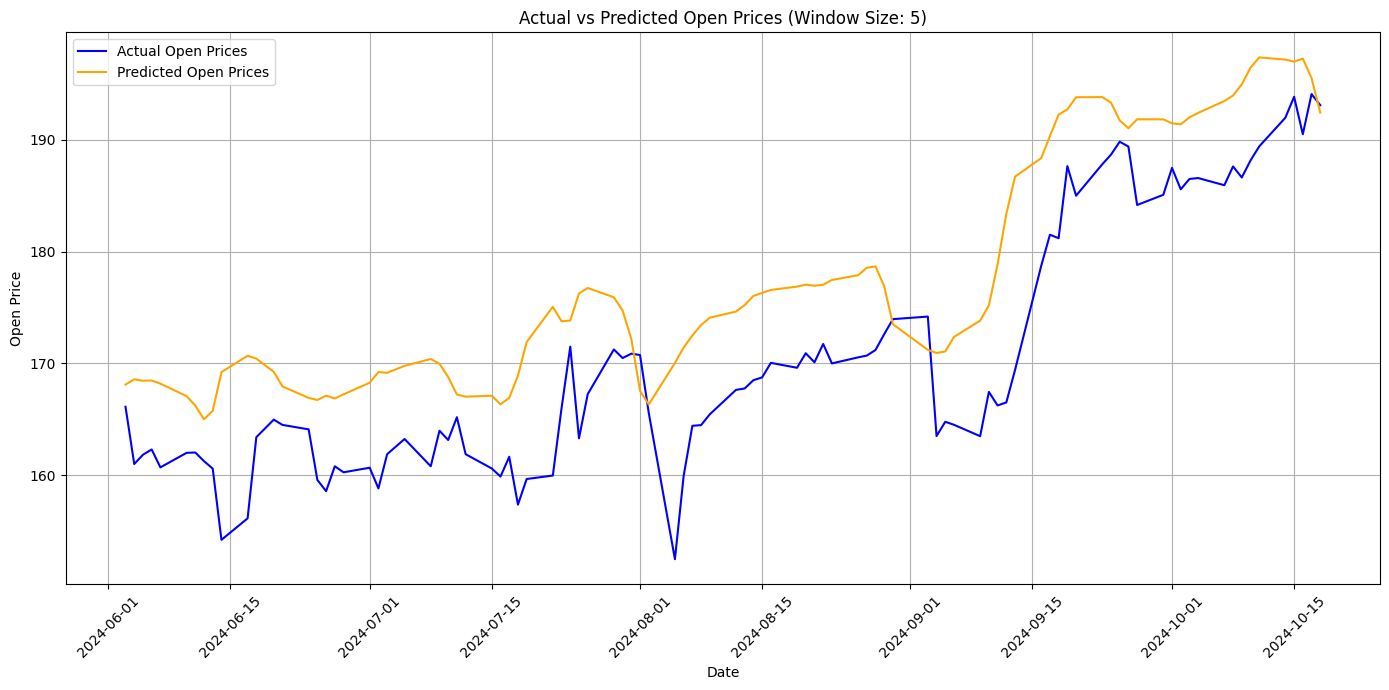

Epoch 1, Train Loss: 0.0048, Val Loss: 0.0002
Epoch 2, Train Loss: 0.0049, Val Loss: 0.0001
Epoch 3, Train Loss: 0.0099, Val Loss: 0.0012
Epoch 4, Train Loss: 0.0559, Val Loss: 0.0007
Epoch 5, Train Loss: 0.0086, Val Loss: 0.0033
Epoch 6, Train Loss: 0.0124, Val Loss: 0.0015
Early stopping triggered.


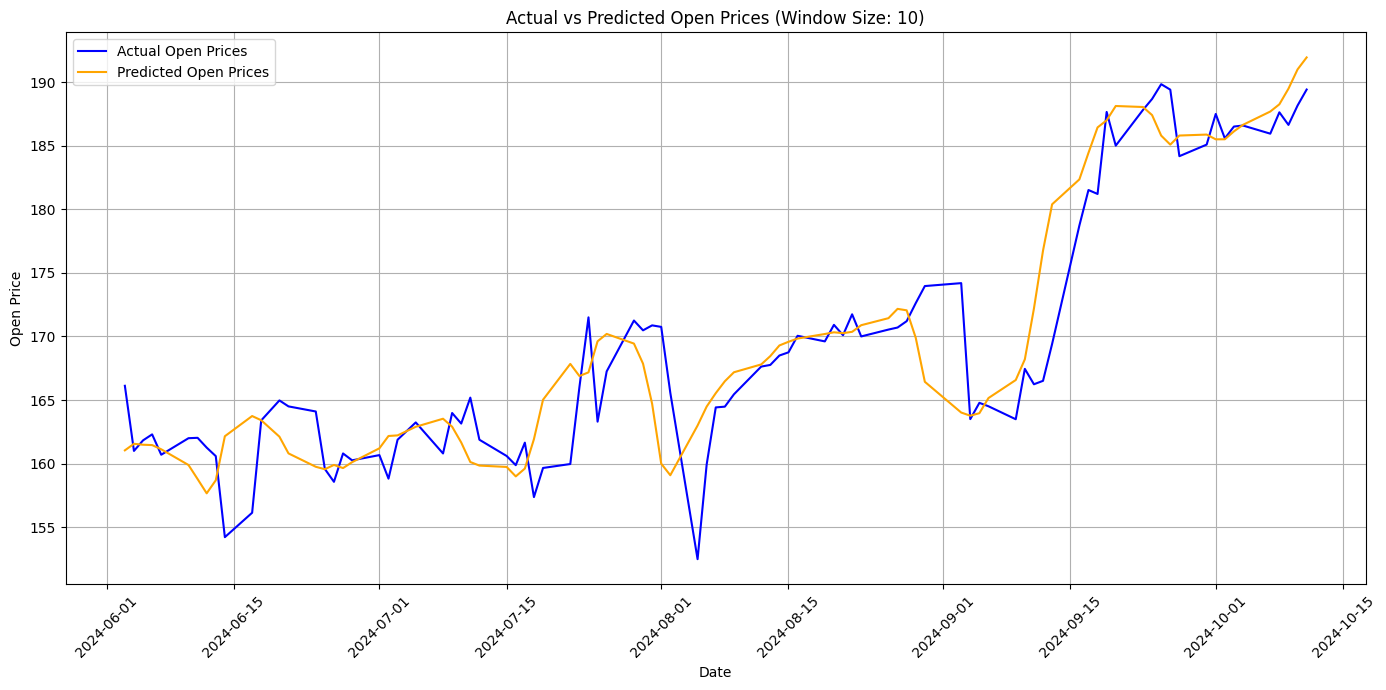

Epoch 1, Train Loss: 0.0012, Val Loss: 0.0058
Epoch 2, Train Loss: 0.0783, Val Loss: 0.0026
Epoch 3, Train Loss: 0.0062, Val Loss: 0.0002
Epoch 4, Train Loss: 0.0041, Val Loss: 0.0023
Epoch 5, Train Loss: 0.0051, Val Loss: 0.0006
Epoch 6, Train Loss: 0.0000, Val Loss: 0.0004
Epoch 7, Train Loss: 0.0011, Val Loss: 0.0000
Epoch 8, Train Loss: 0.0015, Val Loss: 0.0001
Early stopping triggered.


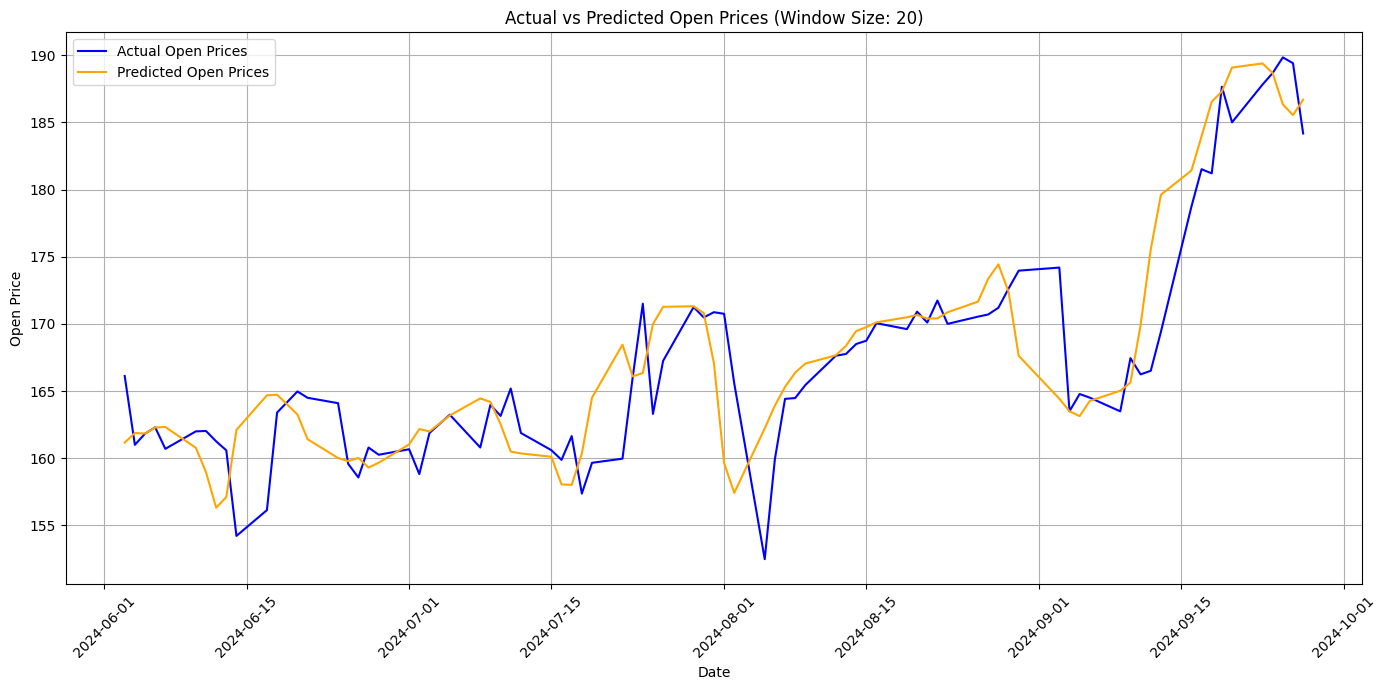

Epoch 1, Train Loss: 0.0003, Val Loss: 0.0010
Epoch 2, Train Loss: 0.0037, Val Loss: 0.0004
Epoch 3, Train Loss: 0.0002, Val Loss: 0.0000
Epoch 4, Train Loss: 0.0010, Val Loss: 0.0003
Epoch 5, Train Loss: 0.0043, Val Loss: 0.0004
Epoch 6, Train Loss: 0.0030, Val Loss: 0.0037
Early stopping triggered.


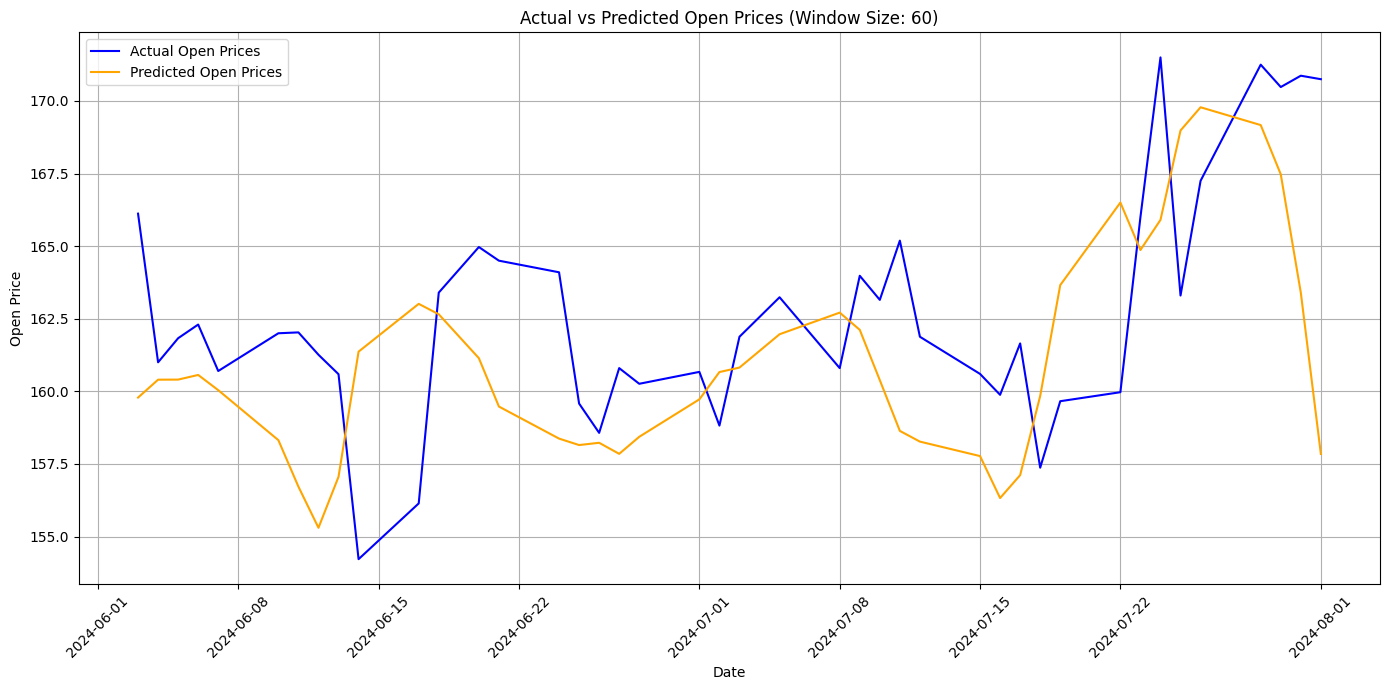

Epoch 1, Train Loss: 0.0153, Val Loss: 0.0047
Epoch 2, Train Loss: 0.0086, Val Loss: 0.0002
Epoch 3, Train Loss: 0.0007, Val Loss: 0.0004
Epoch 4, Train Loss: 0.0018, Val Loss: 0.0002
Epoch 5, Train Loss: 0.0017, Val Loss: 0.0006
Epoch 6, Train Loss: 0.0006, Val Loss: 0.0000
Epoch 7, Train Loss: 0.0107, Val Loss: 0.0008
Early stopping triggered.


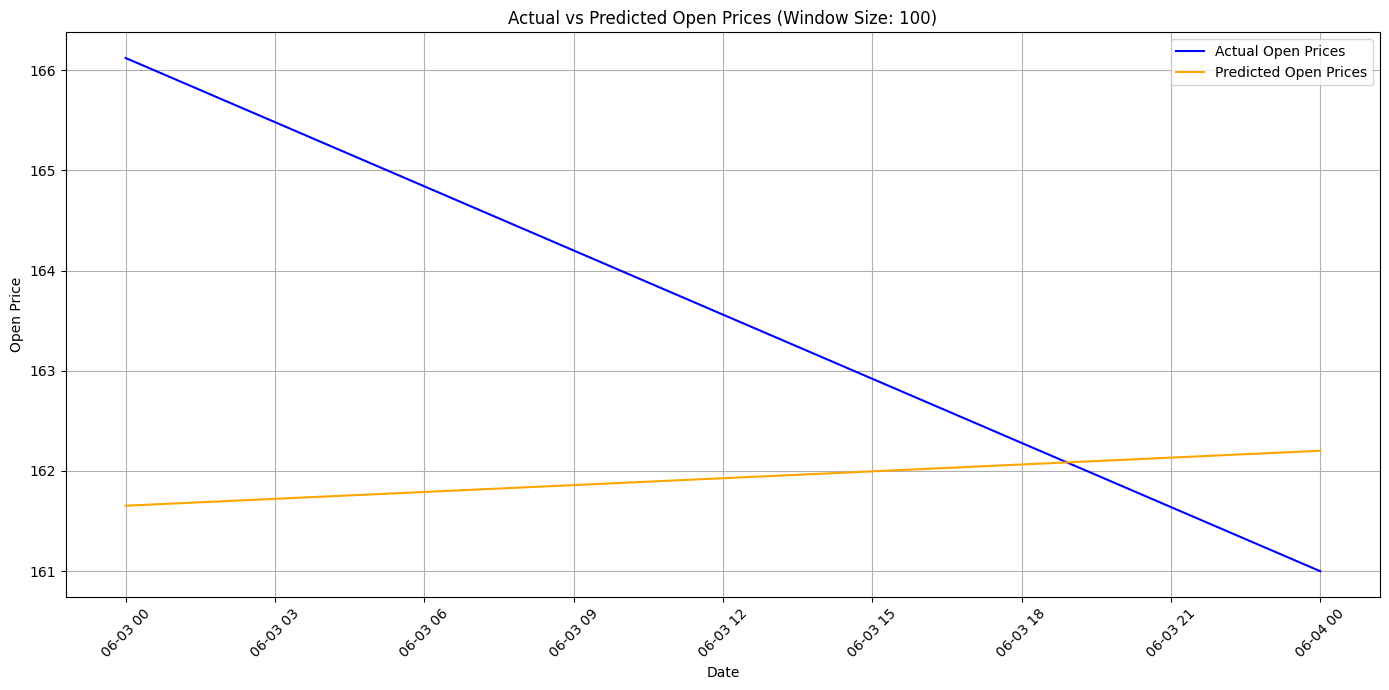

Final MSE: 0.0008
Final MAE: 0.0291
Final R2 Score: -3.8592
   Window Size       MSE       MAE         R²
0            5  0.000516  0.022597  -1.958394
1           10  0.001502  0.038645  -7.607904
2           20  0.000137  0.011459   0.216763
3           60  0.003677  0.060577 -20.078878
4          100  0.000849  0.029052  -3.859177


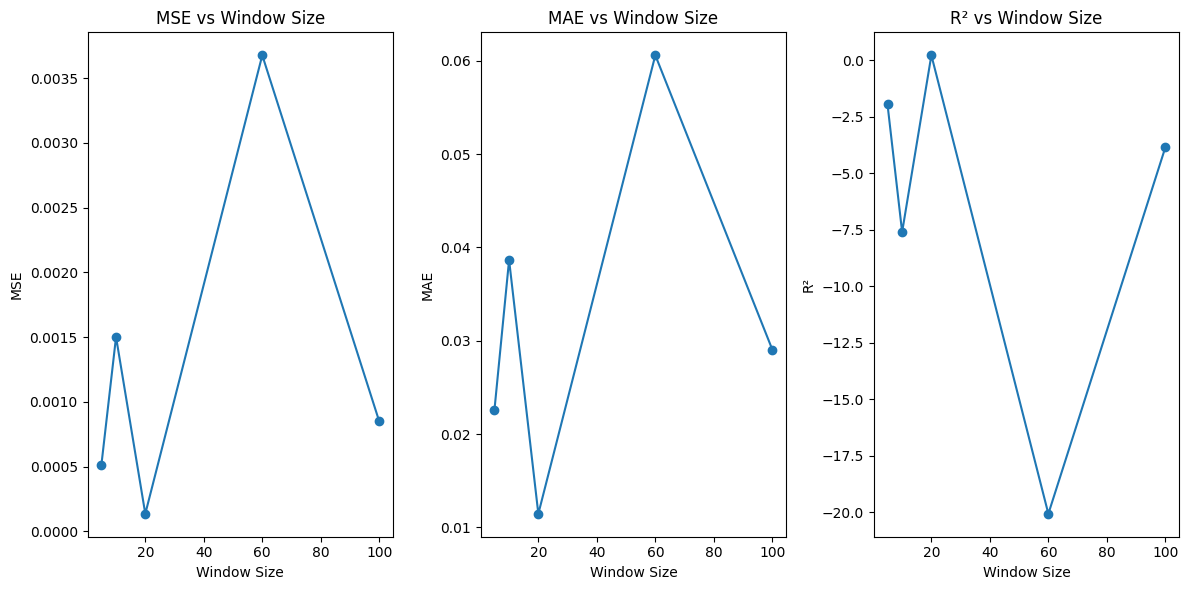

In [ ]:
# %%

# Test different window sizes
window_sizes = [5,10,20,60,100]  # Example window sizes
results = []

batch_size = 32  # Example batch size for training
hidden_size = 64  # Hidden size for LSTM
output_size = 1  # Output size, typically 1 for regression


for window_size in window_sizes:
    mse, mae, r2 = train_model(n_past=window_size, patience=5, min_delta=0.001) 
    results.append({
        'Window Size': window_size,
        'MSE': mse,
        'MAE': mae,
        'R²': r2
    })


# Display results
print(f"Final MSE: {mse:.4f}")
print(f"Final MAE: {mae:.4f}")
print(f"Final R2 Score: {r2:.4f}")

# Create a DataFrame to summarize results
results_df = pd.DataFrame(results)
print(results_df)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(results_df['Window Size'], results_df['MSE'], marker='o')
plt.title('MSE vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('MSE')

plt.subplot(1, 3, 2)
plt.plot(results_df['Window Size'], results_df['MAE'], marker='o')
plt.title('MAE vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('MAE')

plt.subplot(1, 3, 3)
plt.plot(results_df['Window Size'], results_df['R²'], marker='o')
plt.title('R² vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('R²')

plt.tight_layout()
plt.show()